# Plánování v umělé inteligenci
(Základní techniky umělé inteligence)

# Pomocné funkce

TODO (až se už nebude implementace moc měnit): skrýt do pythoního modulu a pouze importovat potřebné funkce

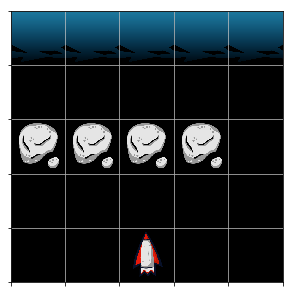

In [10]:
# Pomocne funkce a tridy
# TODO: vyfaktorovat do samostatneho modulu
from collections import namedtuple, defaultdict, deque
import matplotlib.pyplot as plt

IMAGES = {
    name: plt.imread('img/{name}.png'.format(name=name))
    for name in ['spaceship', 'asteroid', 'background-blue-goal']}

Position = namedtuple('Position', ['row', 'col'])


class State:
    def __init__(self, world):
        # TODO: enforce immutability
        # TODO: allow for state[position]
        self.world = world
        self.n = max(pos.row for pos in world) + 1
        self.m = max(pos.col for pos in world) + 1
        # finds spaceship
        self.spaceship = None
        for pos, field in world.items():
            if field == 'S':
                self.spaceship = pos
                break
        # cache wormholes
        wormholes = defaultdict(list)
        for pos, field in world.items():
            if field in 'WXYZ':
                wormholes[field].append(pos)
        self.wormhole_positions = []
        self.wormhole_end = {}
        for letter, positions in wormholes.items():
            if len(positions) != 2:
                continue
                #raise ValueError('Expects exectly 2 wormholes of given type.')
            self.wormhole_positions.extend(positions)
            self.wormhole_end[positions[0]] = positions[1]
            self.wormhole_end[positions[1]] = positions[0]

    def is_goal(self):
        return self.spaceship.row == 0
    
    def show(self):
        return create_spaceworld_fig(self)
#         # TODO: use jupyter-display
#         # hack to overcome bug with empty fields
#         # and to color first row as blue
#         first_row, rest = str(self).split('\n', 1)
#         first_row = first_row.replace('| ', '|b')
#         # use regex..
#         first_row = first_row.replace('|A', '|bA')
#         first_row = first_row.replace('|W', '|bW')
#         first_row = first_row.replace('|M', '|bM')
#         first_row = first_row.replace('|D', '|bD')
#         rest = rest.replace('| ', '|k')
#         text = first_row + '\n' + rest
#         self.world_vis.set(text)
        
    def is_wormhole(self, position):
        return position in self.wormhole_positions
    
    def get_wormhole_end(self, position):
        return self.wormhole_end[position]
        
    def __str__(self):
        # TODO: add __repr__ for debugging (State('''...''')
        fields = [[
            self.world[(Position(row, col))]
            for col in range(self.m)]
                for row in range(self.n)]
        text = '\n'.join('|{inside}|'.format(inside='|'.join(row)) for row in fields)
        #text = text.replace(' ', '.')
        return text

    
def create_spaceworld_fig(state):
    width, height = state.n, state.m
    fig, ax = plt.subplots(figsize=(width, height))
    ax.set_xlim(0, width)
    ax.set_ylim(0, height)
    ax.grid(True)
    ax.set_xticks(range(width+1))
    ax.set_yticks(range(height+1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    ax.patch.set_facecolor('black')   

    def put_img(name, pos):
        x = pos.col
        y = height - pos.row - 1
        ax.imshow(IMAGES[name], extent=[x, x+1, y, y+1])
    
    put_img('spaceship', state.spaceship)
    for x in range(width):
        ax.imshow(
            IMAGES['background-blue-goal'],
            extent=[x, x+1, height-1, height])
    for pos, field in state.world.items():
        if field == 'A':
            put_img('asteroid', pos)            
    return fig    


def perform(state, action):
    raise NotImplementedError('Use "move" instead of "perform"')
    
    
def move(state, action):
    # TODO: thow an error if the resulting state is dead (?)
    # (or allow for representation of dead states)
    world = state.world.copy()
    spaceship = move_spaceship(state.spaceship, action)
    if state.is_wormhole(spaceship):
        spaceship = state.get_wormhole_end(spaceship)
    world[state.spaceship] = ' '
    world[spaceship] = 'S' 
    return State(world)

def move_spaceship(spaceship, action):
    dy = -1
    dx = -1 if action == 'l' else 0 if action == 'f' else 1
    new_spaceship = Position(
        row=spaceship.row + dy,
        col=spaceship.col + dx)
    return new_spaceship    


def actions(state):
    """Return actions that don't lead to dead state.
    """
    return [
        a for a in 'lfr'
        if state.world.get(move_spaceship(state.spaceship, a), 'A') != 'A']     

        
def parse_state(text):
    rows = text.strip().split('||')
    fields = [row.strip('|').split('|') for row in rows]
    world = {}
    spaceship = None
    for r, row in enumerate(fields):
        for c, field in enumerate(row):
            world[Position(r, c)] = field
            if field == 'S':
                spaceship = Position(r, c)
    return State(world) 
        
        
def show_path(path):
    # path = iterable of States
    # Constructs a pseudo-state showing the path
    world = path[0].world.copy()
    for i, state in enumerate(path):
        world[state.spaceship] = str(i)
    print(State(world))
    
    
def show_plan(state, plan):
    # plan = iterable of action
    # Constructs a pseudo-state showing the path
    world = state.world.copy()
    world[state.spaceship] = '0'
    for i, action in enumerate(plan):
        state = move(state, action)
        world[state.spaceship] = str(i)
    print(State(world))
        
        
def is_goal(state):
    # DISQ: Rozmyslet, zde je pro zacatecniky vhodnejsi
    # methoda state.is_goal() nebo funkce is_goal(state).
    return state.is_goal()


state = parse_state(
'| | | | | |'
'| | | | | |'
'|A|A|A|A| |'
'| | | | | |'
'| | |S| | |')
#print(state)
state.show()


# state = parse_state(
# '| | | | | |'
# '| | | |W| |'
# '|A|A|A|A| |'
# '| | | | | |'
# '| | |S| |W|')
# print(state)
# print(state.wormholes)
# print(state.wormhole_end)


# stav: pozice raketky (row, col)
# (zbytek sveta je nemenny)

# akce: 'l', 'f', 'r' (left, forward, right)
#print(perform(perform(perform(state, 'r'), 'r'), 'l'))

In [3]:
# Tools for debugging
class Logger:
    def __init__(self):
        self.output = True
        
    def debug(self, output=True):
        self.output = output
    
    def log(self, message):
        if self.output:
            print(message)
            print('-------')
    
    def log_search_tree(self, parents):
        self.log(search_tree_as_state(parents))

    def log_costs(self, costs, heuristic=None):
        self.log(costs_as_state(costs, heuristic))
        

# def inverse_tree(parents):
#     root = None
#     children = defaultdict(list)
#     for child, parent in parents.items():
#         if parent is None:
#             root = child
#         else:
#             children[parent].append(child)
#     return root, children

def get_root(parents):
    for child, parent in parents.items():
        if parent is None:
            return child
        
def get_depth(node, parents):
    depth = 0
    while parents[node] is not None:
        node = parents[node]
        depth += 1
    return depth

def search_tree_as_state(parents):
    #root, children = inverse_tree(parents)
    root = get_root(parents)
    world = root.world.copy()
    for state in parents.keys():
        depth = get_depth(state, parents)
        world[state.spaceship] = str(depth)
    return State(world)    
    
def show_search_tree(parents):
    print(search_tree_as_state(parents))   

def costs_as_state(costs, heuristic=None):
    heuristic = heuristic or (lambda x: 0)
    world = next(iter(costs.keys())).world.copy()
    for state in costs.keys():
        total_cost = costs[state] + heuristic(state)
        world[state.spaceship] = str(total_cost)
    return State(world)


LOGGER = Logger()

In [4]:
# from IPython.display import SVG
# svg="""
# <svg xmlns="http://www.w3.org/2000/svg">
#     <rect x="10" y="10" height="80" width="80" style="fill: #0000ff"/>
# </svg>"""
# SVG(svg)

In [5]:
# import ipywidgets as widgets

# w = widgets.IntSlider()
# display(w)

# file = open("img/spaceship.png", "rb")
# image = file.read()
# items = [
# widgets.Image(
#     value=image,
#     format='png',
#     width=40,
#     height=40,
# ) for i in range(4)]
# left_box = widgets.VBox([items[0], items[1]])
# right_box = widgets.VBox([items[2], items[3]])
# widgets.HBox([left_box, right_box])

# Hledání cesty ve vesmíru

TODO: popis problému a jeho komponent

**Problém:**
Hledáme cestu pro raketku ve vesmíru. Prostředí tvoří mřížka, některá políčka jsou zablokovaná asteroidy. Raketka začíná někde na spodním řádku a musí doletět do horního řádku.

In [6]:
state = parse_state(
'| | | | | |'
'| | | | | |'
'|A|A|A|A| |'
'| | | | | |'
'| | |S| | |')
state.show()

# TODO: todo improve state.show() to center the plan and insert
# some vertical spacing

**Akce:**
Raketka letí stále vpřed a může přitom zatáčet doleva a doprava (dostoupné jsou tedy tři akce: 'l' jako 'left', 'f' jako 'forward', 'r' jako 'right'.

In [7]:
# Funkce `actions` vraci akce dostupne v danem stavu.
actions(state)

['l', 'f', 'r']

In [8]:
# Funkce `move(s, a)` vraci stav, ktery vznikne ze stavu s
# po provedeni akce a:
next_state = move(state, 'r')
next_state.show()

In [9]:
# V nekterych stavech jsou dostupne pouze nektere akce:
actions(next_state)

['r']

**Stav:** kóduje to, co se světe mění při provádění akcí.
V našem případě se mění pouze pozic raketky, stav je tedy dvojice (řádek, sloupec).

TODO: rozmyslet, zatim se zda byt pohodlne do stavu schovat i nemennou cast sveta (prostredi).

TODO: ilustrovat

**Cílový stav** je takový stav, ve kterém se raketka nachází na horním řádku. Pro testování cílovosti stavu použijte funkci `is_goal(state)`.

In [10]:
# Ukazka stavu, ktery neni cilovy.
state = parse_state(
'| | | | | |'
'| | | | | |'
'|A|A|A|A| |'
'| | | | | |'
'| | |S| | |')
is_goal(state)

False

In [11]:
# Ukazka stavu, ktery je cilovy.
state_b = parse_state(
'| | | |S| |'
'| | | | | |'
'|A|A|A|A| |'
'| | | | | |'
'| | | | | |')
is_goal(state_b)

True

**Plán:** Řešením problému je posloupnost akcí, které musí raketka vykonat, aby se dostala do cíle.


In [12]:
# TASK: zadat pouze castecny plan a nechat dopsat tak,
# aby raketka doletela do cile
plan = ['r', 'r', 'f', 'l']
show_plan(state, plan)

# TODO: implement show_plan
# to show the world with the path draw as a line
# + int-widget to show current state (= to animate the path)

| | | |3| |
| | | | |2|
|A|A|A|A|1|
| | | |0| |
| | |0| | |


In [13]:
import ipywidgets as widgets

w = widgets.IntSlider()
display(w)

file = open("img/spaceship.png", "rb")
image = file.read()
items = [
widgets.Image(
    value=image,
    format='png',
    width=40,
    height=40,
) for i in range(4)]
left_box = widgets.VBox([items[0], items[1]])
right_box = widgets.VBox([items[2], items[3]])
widgets.HBox([left_box, right_box])

A Jupyter Widget

A Jupyter Widget

In [14]:
# show_plan(state, plan)

def show_plan_step(initial_state, plan, step):
    return ''.join(plan) + str(step)

plan = ['r', 'r', 'f', 'l']
step = widgets.IntSlider(
    min=0, max=len(plan),
    value=0,
    description='Krok')
widgets.interact(
    show_plan_step,
    initial_state=widgets.fixed(state),
    plan=widgets.fixed(plan),
    step=step)

A Jupyter Widget

<function __main__.show_plan_step>

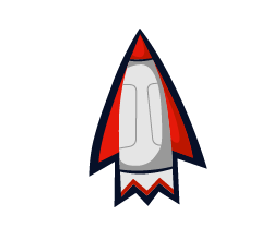

In [9]:
import matplotlib.pyplot as plt
# with open('img/spaceship.png') as f:
#     image = plt.imread(f)
# fig, ax = plt.subplots()
# ax.imshow(image)
# ax.axis('off')  # clear x- and y-axes
# plt.show()

image = plt.imread('img/spaceship.png')
fig, ax = plt.subplots()
ax.imshow(image)
ax.axis('off')
fig

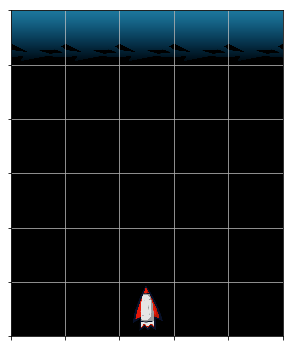

In [30]:
# import bokeh
# from bokeh.plotting import figure, show, output_file

# p = figure(x_range=(0,1), y_range=(0,1))
# p.image_url(url=['img/spaceship.png'], x=0, y=1, w=1, h=1)
# show(p)

**Cesta** je posloupnost stavů. Cestu můžeme dostat postupnou aplikací akcí na nějaký počáteční stav.

TODO: Potrebujeme tento pojem? Pokud ne, tak vynechat. Pokud ano, tak ilustrovat.

### Problém hledání cesty - shrnutí

Problém hledání cesty se skládá z těchto komponent:

* počáteční stav,
* funkce `actions(s)` vracející akce dostupné ve stavu *s*,
* funkce `move(s, a)` vracející nový stav, který vznikne ze stavu *s* provedením akce *a*,
* funkce `is_goal(s)` vracející *True* právě tehdy, když je *s* cílový stav.

Pro vizualizaci stavu, plánu a prohledávacího stromu můžete použít připravené funkce:
* `show_state(s)`
* `show_plan(initial_state, plan)`
* TODO: `show_search_tree` ??

# Greedy Search (Hladové hledání)

Na rozehřátí začneme značným zjednodušením: budeme předpokládat, že je v každém kroku bezpečné použít libovolnou z dostupných akcí, tj. že na mapě nejsou žádné "slepé uličky".

V takovém případě je tvorba plánu jednoduchá: vybíráme jakoukoliv dostupnou akci, dokud se nedostaneme do cíle.

In [87]:
# TASK: Implementujte funkci greedy_search(initial_state),
# ktera vraci plan pro cestu z initial_state do cile.
# Budete potrebovat funkce: actions(s), move(s, a), is_goal(s).
# Prace se seznamem reprezentujicim plan akci:
# 1. vytvoreni prazdneho planu: plan = []
# 2. rozsireni planu o jednu akci: plan.append(action)

def greedy_search(initial_state):
    state = initial_state
    plan = []
    while not is_goal(state):
        available_actions = actions(state)
        if not available_actions:
            break # Failed to find a path.
        # Choose the first available action (greedy choice).
        action = available_actions[0]
        state = move(state, action)
        plan.append(action)
    # Return a complete or a partial path.
    return plan

state = parse_state(
'|A|A| |A|A|'
'|A|A| |A|A|'
'|A| |A|A|A|'
'|A|A| |A|A|'
'|A|A|S|A|A|')
plan = greedy_search(state)
show_plan(state, plan)

|A|A|3|A|A|
|A|A|2|A|A|
|A|1|A|A|A|
|A|A|0|A|A|
|A|A|0|A|A|


In [88]:
# Greedy search bude fungovat i v pripade hodne
# ridce rozmistenych prekazek.
state = parse_state(
'| | | | | |'
'|A| |A| |A|'
'| | | | | |'
'|A| |A| |A|'
'| | | | | |'
'| | |S| | |')
plan = greedy_search(state)
show_plan(state, plan)

|4| | | | |
|A|3|A| |A|
|2| | | | |
|A|1|A| |A|
| |0| | | |
| | |0| | |


In [89]:
# Obecne ale greedy search zadnou cestu do cile najit nemusi,
# je mozne, ze se zasekne (ve "slepe ulicce").
state = parse_state(
'| | | | | |'
'|A|A| |A|A|'
'| | | | | |'
'| |A|A|A| |'
'| | | | | |'
'| | |S| | |')
plan = greedy_search(state)
show_plan(state, plan)

| | | | | |
|A|A| |A|A|
|2| | | | |
|1|A|A|A| |
| |0| | | |
| | |0| | |


Poznámky:
* Do hladového algoritmu lze snadno zakomponovat prefernci některých akcí (např. protože jsou některé akce levnější než jiné, nebo protože nás posunou blíže k cíli) - rozmyslete si jak (co by bylo potřeba v algoritmu upravit).

# Prohledávání do hloubky (DFS)

Obecně tedy nestačí uvažovat pouze jednu z dostupných akcí. Je možné že se při prohledávání budeme muset "vrátit na rozcestí" a vykonat nějakou jinou akci. Takovýto "průchod s návratem" lze reprezentovat pomocí tzv. *prohledávacího stromu* (anglicky *search tree*), ve kterém vrcholy reprezentují možné stavy a hrany akce, které převádějí jeden stav do druhého.

In [93]:
# Ukazka prohledavaciho stromu. Nejprve si vytvorime nekolik stavu.
s0 = parse_state(
'| | | | | |'
'| | | | | |'
'|A|A|A|A| |'
'| | | | | |'
'| | |S| | |')
s1 = move(s0, 'l')
s2 = move(s0, 'f')
s3 = move(s0, 'r')
s4 = move(s3, 'r')
# Strom pak zadefinujeme jako slovnik mapujici vrcholy (stavy)
# na jejich predchudce. Koren stromu (pocacecni stavu) se 
# mapuje na None.
tree = {
    s0: None,
    s1: s0,
    s2: s0,
    s3: s0,
    s4: s3,
}
show_search_tree(tree)

# TODO: Vylepsit show_search_tree (pekne obrazek s hranami)
# a barevne odlisenymi typy vrcholu (explored vs. frontier)

| | | | | |
| | | | | |
|A|A|A|A|2|
| |1|1|1| |
| | |0| | |


Během prohledávání budeme rozlišovat stavy, které jsme ještě neviděli, tj. nejsou ještě součástí prohledávacího stromu,
a stavy,které jsme už potkali, tj. jsou součástní prohledávacího stromu.
Tyto se hodí ještě dále rozdělit na jeho listy (TODO: zobrazené na obrázku nějakou barvou), tj. stavy na okraji (`frontier`),
a vnitřní vrcholy (TODO: zobrazené nějakou jinou barvou), ty budeme považovat za prozkoumané (`explored`).

In [9]:
# Tree-DFS pomoci rekurze (nehlida zacykleni)
def dfs(state):
    """Return path from state to a goal state"""
    #print('---\nstate:\n' + str(state))
    #input()
    if state.is_goal():
        return [state]
    for action in actions(state):      
        next_state = perform(state, action)
        path = dfs(next_state)
        if path:
            return [state] + path
    return None  # no path found

state = parse_state(
'| | | | | |'
'| | | | | |'
'|A|A|A|A| |'
'| | | | | |'
'| | |S| | |')
show_path(dfs(state))

| | |4| | |
| | | |3| |
|A|A|A|A|2|
| | | |1| |
| | |0| | |


In [25]:
# Rekurzivni graph-dfs (hlidajici zacykleni)
def recursive_graph_dfs(start_state):
    explored = set()
    def dfs(state):
        explored.add(state)
        if state.is_goal():
            return [state]
        for action in actions(state):      
            next_state = perform(state, action)
            if next_state in explored:
                continue
            path = dfs(next_state)
            if path:
                return [state] + path
        return None  # no path found
    return dfs(start_state)

state = parse_state(
'| | | | | |'
'| | | | | |'
'|A|A|A|A| |'
'| | | | | |'
'| | |S| | |')
show_path(recursive_graph_dfs(state))

| | |4| | |
| | | |3| |
|A|A|A|A|2|
| | | |1| |
| | |0| | |


In [10]:
# Zasobnik = pridavame a odebirame ze stejneho konce,
# napr. stos knih, naskladane talire.
stack = ['a', 'b', 'c']  # vrchol zasobniku je vpravo ('c')
stack.append('d')  # pridani 'd' na vrchol zasobniku
print(stack)  # ['a', 'b', 'c', 'd']
stack.pop()  # odebrani prvku 'd' z vrcholu zasobniku
print(stack)  # ['a', 'b', 'c']
stack.pop()  # odebrani prvku 'c' z vrcholu zasobniku
print(stack)  # ['a', 'b']

['a', 'b', 'c', 'd']
['a', 'b', 'c']
['a', 'b']


In [11]:
# Terminology: tree vs. parents?
def reconstruct_path(tree, state):
    reversed_path = []
    while state is not None:
        reversed_path.append(state)
        state = tree[state]
    path = list(reversed(reversed_path))
    return path

    
# tree search - bez kontroly zacykleni
def iterative_dfs(initial_state):
    stack = [initial_state]
    tree = {initial_state: None}  # maps nodes to their parents
    while stack:
        LOGGER.log_search_tree(tree)
        state = stack.pop()
        if state.is_goal():
            return reconstruct_path(tree, state)
        for action in actions(state):
            next_state = perform(state, action)
            stack.append(next_state)
            tree[next_state] = state
            

LOGGER.debug(False)
state = parse_state(
'| | | | | |'
'| | | | | |'
'|A|A|A|A| |'
'| | | | | |'
'| | |S| | |')
show_path(iterative_dfs(state))

| | | | |4|
| | | | |3|
|A|A|A|A|2|
| | | |1| |
| | |0| | |


In [32]:
# graph search - bez duplicitnich vypoctu a moznosti zacykleni

# TODO: potreba motivovat prikladem (zacykleni by potrebovalo
# cervi diry, ale redundantni vypocty lze i bez toho)

# Nasledujici algoritmus neprochazi vrcholy v korektnim DFS poradi,
# protoze pridava do zasobniku vsechny zkoumaneho stavu najednou
# a nikdy podruhe (pro zachovani liearni velikosti zasobniku).
# Pri hledani cesty k cilovemu stavu to nicemu nevadi, ale je
# dobre vedet, ze to neni presne DFS a pro nektere jine aplikace
# (napr. detekce orientovanych cyklu) by byl kod potreba upravit.
def graph_dfs(initial_state):
    stack = [initial_state]
    # tree - mapuje stavy na jejich rodice
    # v tomto pripade ukladame vrcholy do stromu
    # uz pri jejich videni 
    tree = { initial_state: None }
    while stack:
        state = stack.pop()
        LOGGER.log_search_tree(tree)
        if state.is_goal():
            return reconstruct_path(tree, state)
        for action in reversed(actions(state)):
            next_state = perform(state, action)
            # Vrcholy ukladame do stromu uz pri jejich videni.
            # To nam umozni linearni velikost zasobniku
            # (kazdy vrchol tam bude nejvyse jednou.)
            if next_state not in tree:  # uz jsme ho videli
                tree[next_state] = state
                stack.append(next_state)

LOGGER.debug(False)
state = parse_state(
'| | | | | |'
'| | | | | |'
'|A|A|A|A| |'
'| | | | | |'
'| | |S| | |')
show_path(graph_dfs(state))            

| | |4| | |
| | | |3| |
|A|A|A|A|2|
| | | |1| |
| | |0| | |


Co DFS nezvladne: pokud nejsou reseni ve stejne hloubce (a pritom chceme najit optimalni cestu). Priklad s cervimi dirami:

In [13]:
LOGGER.debug(False)
state = parse_state(
'| | | | | |'
'| | | |W| |'
'| | | | | |'
'| | |W| | |'
'| | |A| | |'
'| | |S| | |')
show_path(graph_dfs(state))

| | | | |5|
| | | |W|4|
| | | | |3|
| | |W| |2|
| | |A|1| |
| | |0| | |


# BFS (Breadth-first search)

In [14]:
# Fronta = usporadana kolekce prvku, odebirame a pridavame na opacne
# konce, jako u bezne fronty napr. v obchode.
queue = deque(['a', 'b', 'c'])  # 'a' na zacatku fronty, 'c' na konci
queue.append('d')  # 'd' prisel na konec fronty
print(queue)  # deque(['a', 'b', 'c', 'd'])
queue.popleft()  # odchazi 'a'
print(queue)  # deque(['b', 'c', 'd'])
queue.popleft()  # odchazi 'b'
print(queue)  # deque(['c', 'd'])

deque(['a', 'b', 'c', 'd'])
deque(['b', 'c', 'd'])
deque(['c', 'd'])


In [15]:
# TODO: svet, ktery nejde optimalne resit pomoci DFS
# (cervi diry nebo nestejna hloubka reseni)

In [16]:
def bfs(initial_state):
    if initial_state.is_goal():
        return [initial_state]
    queue = deque([initial_state])
    tree = {initial_state: None}  # maps states to their parents
    while queue:
        LOGGER.log_search_tree(tree)
        state = queue.popleft()
        for action in actions(state):
            next_state = perform(state, action)
            if (next_state in tree.keys()
                or next_state in queue):
                continue
            queue.append(next_state)
            tree[next_state] = state
            # U BFS lze test na cilovy stav provadet uz zde.
            if next_state.is_goal():
                return reconstruct_path(tree, next_state)

# LOGGER.debug(False)
# state = parse_state(
# '| | | | | |'
# '| | | | | |'
# '|A|A|A|A| |'
# '| | | | | |'
# '| | |S| | |')
# show_path(bfs(state))
LOGGER.debug(False)
state = parse_state(
'| | | | | |'
'| | | |W| |'
'| | | | | |'
'| | |W| | |'
'| | |A| | |'
'| | |S| | |')
show_path(bfs(state))

| | |3| | |
| | | |2| |
| | | | | |
| | |W| | |
| |1|A| | |
| | |0| | |


# Uniform Cost Search (UCS) (Dijkstra)

Přidání cen akcí -> DFS ani BFS nestačí.

Příklad cen: let dopředu 2, let vlevo/vpravo 3.
(nebo lze pridat strileni s vyssi cenou)

In [17]:
# # TODO: vysvetlit prioritni haldu
# from heapq import heappush, heappop

# queue = []
# heappush(queue, (5, 'a'))  # Vkladame prvek 'a' s prioritou 5.
# heappush(queue, (3, 'b'))  # Vkladame prvek 'b' s prioritou 3.
# heappush(queue, (7, 'c'))  # Vkladame prvek 'c' s prioritou 7.
# print(queue)  # [(3, 'b'), (5, 'a'), (7, 'c')]
# print(heappop(queue)) # (3, 'b')
# print(queue)  # [(5, 'a'), (7, 'c')]
# print(heappop(queue)) # (5, 'a')
# print(queue)  # [(7, 'c')]

costs = {}
costs['a'] = 5
costs['b'] = 3
costs['c'] = 7
min(costs, key=lambda x: costs[x])

'b'

In [18]:
from math import inf
ACTION_COSTS = {'l': 3, 'f': 2, 'r': 3}

def ucs(initial_state):
    # Ke kazdeme videnemu stavu ulozime jeho rodice.
    tree = {initial_state: None}
    # Do fronty ukladame dvojice (cena, stav).
    #queue = [(0, initial_state)]
    # Budeme zvlast ukladat vsechny ceny (i do jiz prozkoumanych
    # vrcholu) a okraj (vrcholy k prozkoumani).
    costs = {initial_state: 0}
    fringe = {initial_state}
    while fringe:
        LOGGER.log_costs(costs)
        #cost, state = heappop(queue)
        state = min(fringe, key=lambda s: costs[s])
        fringe.remove(state)
        if state.is_goal():
            return reconstruct_path(tree, state)
        for action in actions(state):
            next_state = perform(state, action)
            new_cost = costs[state] + ACTION_COSTS[action]
            old_cost = costs.get(next_state, inf)
            if new_cost < old_cost:
                fringe.add(next_state)
                costs[next_state] = new_cost
                tree[next_state] = state
            
LOGGER.debug(False)
state = parse_state(
'| | | | | |'
'| | | | | |'
'|A|A|A|A| |'
'| | | | | |'
'| | |S| | |')
show_path(ucs(state))

| | | | |4|
| | | | |3|
|A|A|A|A|2|
| | | |1| |
| | |0| | |


# A*

Kombinace UCS a heuristiky.

Příklad heuristiky: vertikální vzdálenost od cíle (komplikovanější heuristiky můžou brát v úvahu počet posbíraných diamantů).

TODO: ukázat příklad, kdy UCS prohledává zbytečně moc (potřeba červích děr nebo diamantů) a jak to vyřešit pomocí jednoduché heuristiky

In [19]:
def heuristic_distance(state):
    return state.spaceship.row

In [20]:
heuristic_distance(parse_state(
'| | | | | |'
'| | | | | |'
'|A|A|A|A| |'
'| | |S| | |'
'| | | | | |'))

3

In [21]:
heuristic_distance(parse_state(
'| | |S| | |'
'| | | | | |'
'|A|A|A|A| |'
'| | | | | |'
'| | | | | |'))

0

In [22]:
# Jako UCS, lisi se jen vypoctem ceny.
def a_star(initial_state, heuristic):
    # Ke kazdeme videnemu stavu ulozime jeho rodice.
    tree = {initial_state: None}
    # Do fronty ukladame dvojice (cena, stav).
    #queue = [(0, initial_state)]
    # Budeme zvlast ukladat vsechny ceny (i do jiz prozkoumanych
    # vrcholu) a okraj (vrcholy k prozkoumani).
    costs = {initial_state: 0}
    fringe = {initial_state}
    while fringe:
        LOGGER.log_costs(costs, heuristic)
        #cost, state = heappop(queue)
        # Jedina zmena oproti UCS:
        state = min(fringe, key=lambda s: costs[s] + heuristic(s))
        fringe.remove(state)
        if state.is_goal():
            return reconstruct_path(tree, state)
        for action in actions(state):
            next_state = perform(state, action)
            new_cost = costs[state] + ACTION_COSTS[action]          
            old_cost = costs.get(next_state, inf)
            if new_cost < old_cost:
                fringe.add(next_state)
                costs[next_state] = new_cost
                tree[next_state] = state
            
LOGGER.debug(False)
state = parse_state(
'| | | | | |'
'| | | | | |'
'|A|A|A|A| |'
'| | | | | |'
'| | |S| | |')
show_path(a_star(state, heuristic=heuristic_distance))

| | | | |4|
| | | | |3|
|A|A|A|A|2|
| | | |1| |
| | |0| | |


## TODO

- intro
- DFS
- DFS - explain tree search vs. graph search
- nastroje pro pohodlne ladeni vsech algoritmu (vizualizace cesty i prubehu planovani (explored/frontier/unexplored states) -> umoznit vypisy (ala logger), vcetne textovych (-> muzu zkopirovat text stavu a vyzkouset si zacit z neho atp.)
- DFS - recursive version
- BFS (motivace: cervi diry - DFS nemusi najit nejkratsi cestu)
- UCS
- A\*
- refaktorovat (zprehlednit, zjednodusit, okomenotvat) kod
- inline react component for visualizing states, paths (and ideally also allow to play the game... or at least provide a link to task-editor)
- rezerva: greedy search, BF, DP, "patnáctka" (sliding tiles)
- parsovani sveta (jako v JS)
- vyfaktorovat pomocné funkce do samostatného .py modulu
- hezčí vykreslování stavu (HTML tabulka, react components)
- another notebook with stripped solutions
- inspirace: Jak to vyresit, Programatorska cvicebnice, Sbirka do Navalu, KSI (napr. Honzovo bludiste, davna DFS/BFS videa), Ucadity AI, EdX AI lecture, google
- testing by friends
- utopicke: pridat jako dalsi level do RoboMise (s pripravenymi high-level bloky a/nebo v RoboKodu)

## Rozšíření
* protihráč -> minimax
* náhoda, nejistota -> expectimax, MDP (value iteration - DP)
* too many states (even infinitely many of them)
* continuous actions
* ...

## Další zdroje
* TBA: videa z AI kurzu na EdX